In [1]:
!pip install transformers torch matplotlib --quiet


# Example notebook - Explainability

In [2]:
import torch
from transformers import BertTokenizer, BertModel, pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE



## Attention Visualization

Attention mechanisms are widely used in natural language processing (NLP) and computer vision tasks, allowing models to focus on relevant parts of the input data. Attention visualization techniques, such as attention heat maps or saliency maps, can highlight the regions or tokens in the input that the model is paying attention to, providing insights into its decision-making process. 

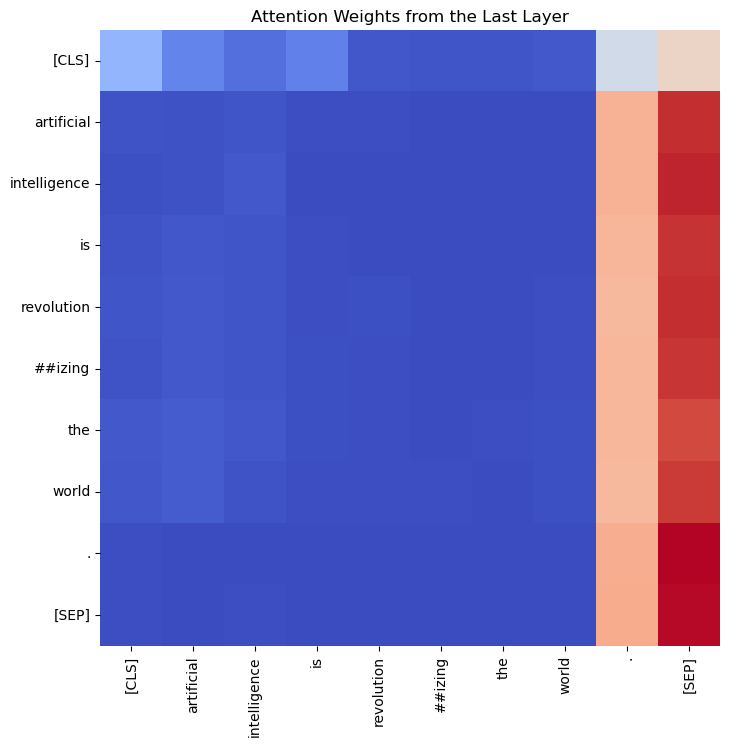

In [7]:

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)

# Sample text
text = "Artificial intelligence is revolutionizing the world."

# Tokenize input
inputs = tokenizer(text, return_tensors="pt")

# Get attention weights from model
outputs = model(**inputs)
attentions = outputs.attentions

# Visualize attention from the last layer
attention = attentions[-1][0][0].detach().numpy()

# Plot heatmap of attention weights
fig, ax = plt.subplots(figsize=(8, 8))  # Reduced size for better visualization
sns.heatmap(attention, 
            xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), 
            yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), 
            cmap="coolwarm", ax=ax, cbar=False)  # Changed color map to 'coolwarm' and removed color bar
plt.title('Attention Weights from the Last Layer')
plt.show()


## Concept Activation Vectors (CAVs)

CAVs are interpretability techniques that identify the high-level concepts or semantic concepts that a model is sensitive to, enabling a better understanding of its decision-making criteria. By analyzing the model's activation patterns in response to specific concepts, CAVs can reveal the model's internal representations and the concepts it deems important for various tasks.

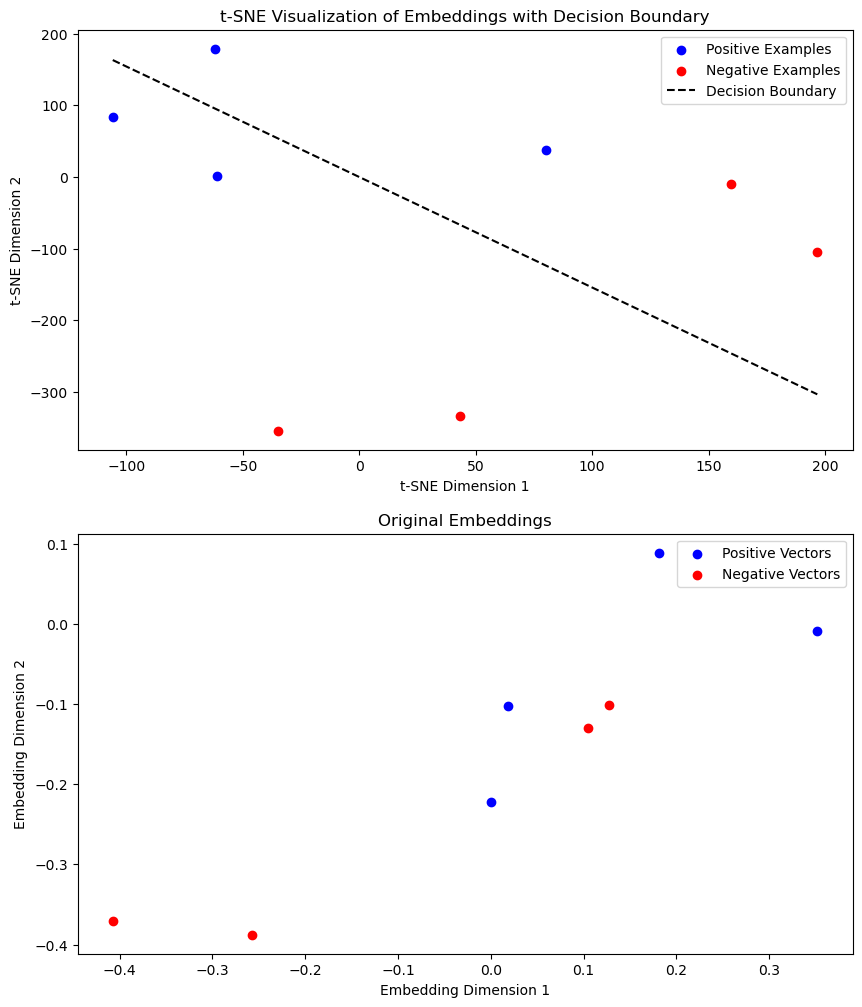

In [11]:


# Create synthetic examples for the concept "good customer service"
positive_examples = ["excellent service", "friendly staff", "helpful support", "quick response"]
negative_examples = ["rude service", "unfriendly staff", "unhelpful support", "slow response"]

# Tokenize and encode these examples
positive_inputs = tokenizer(positive_examples, return_tensors="pt", padding=True, truncation=True)
negative_inputs = tokenizer(negative_examples, return_tensors="pt", padding=True, truncation=True)

# Get embeddings from BERT model
positive_embeddings = model(**positive_inputs).last_hidden_state.mean(dim=1).detach().numpy()
negative_embeddings = model(**negative_inputs).last_hidden_state.mean(dim=1).detach().numpy()

# Labels for our synthetic examples
labels = [1] * len(positive_examples) + [0] * len(negative_examples)

# Combine data
data = np.concatenate((positive_embeddings, negative_embeddings))

# Reduce dimensionality using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=0, perplexity=3)
data_2d = tsne.fit_transform(data)

# Train a linear classifier to find the CAV
clf = SGDClassifier().fit(data, labels)
cav = clf.coef_

# Plot the data points and the decision boundary
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# t-SNE visualization
positive_points = data_2d[:len(positive_examples)]
negative_points = data_2d[len(positive_examples):]

axs[0].scatter(positive_points[:, 0], positive_points[:, 1], c='blue', label='Positive Examples')
axs[0].scatter(negative_points[:, 0], negative_points[:, 1], c='red', label='Negative Examples')

# Plot the decision boundary
x_vals = np.linspace(min(data_2d[:, 0]), max(data_2d[:, 0]), 100)
# Project the CAV onto the 2D t-SNE space
y_vals = -(cav[0][0] * x_vals) / cav[0][1]

axs[0].plot(x_vals, y_vals, '--', c='black', label='Decision Boundary')
axs[0].set_title('t-SNE Visualization of Embeddings with Decision Boundary')
axs[0].set_xlabel('t-SNE Dimension 1')
axs[0].set_ylabel('t-SNE Dimension 2')
axs[0].legend()

# Plot the original vectors for completeness
axs[1].scatter(data[:len(positive_examples), 0], data[:len(positive_examples), 1], c='blue', label='Positive Vectors')
axs[1].scatter(data[len(positive_examples):, 0], data[len(positive_examples):, 1], c='red', label='Negative Vectors')
axs[1].set_title('Original Embeddings')
axs[1].set_xlabel('Embedding Dimension 1')
axs[1].set_ylabel('Embedding Dimension 2')
axs[1].legend()

plt.show()



In [12]:
print(f"Concept Activation Vector (CAV) for 'good customer service': {cav}")


Concept Activation Vector (CAV) for 'good customer service': [[ 6.66467237e+00  4.31908178e+00 -2.80520892e+00 -6.59475446e-01
   6.36709690e-01 -3.91901946e+00 -1.44930220e+00  7.13408768e-01
  -3.39700913e+00  1.92077935e+00 -5.34080565e-01 -4.37377930e+00
   4.60134172e+00 -3.93176436e+00 -2.57356405e+00 -4.05703592e+00
   4.51352549e+00 -7.14679480e-01 -4.75821167e-01  3.15828896e+00
   1.87386596e+00  7.33381927e-01 -7.54061460e-01  4.42057800e+00
   1.51446790e-01 -3.31174779e+00  1.71860778e+00  3.45891595e+00
   5.68791819e+00 -1.64521027e+00  1.58896148e+00 -4.56114817e+00
  -4.30657446e-01  7.18699598e+00  3.93531704e+00  2.93041182e+00
   3.05983710e+00  7.46040630e+00 -7.71749449e+00  1.61092651e+00
   8.25516319e+00  5.98250818e+00  4.71852064e+00  6.29337263e+00
   1.60051358e+00 -8.07665730e+00  3.22377115e-01  1.78149021e+00
   3.43225789e+00  2.13387966e+00  2.68881011e+00 -1.63029715e-01
  -8.06118584e+00  4.17528677e+00  1.90961897e+00  4.34728098e+00
  -9.84866798e-

## Counterfactual Explanations

Counterfactual explanations provide insights into how the model's output would change if certain input features or conditions were different. By generating and analyzing counterfactual examples, you can better understand the model's decision boundaries and the factors that influence its outputs. 

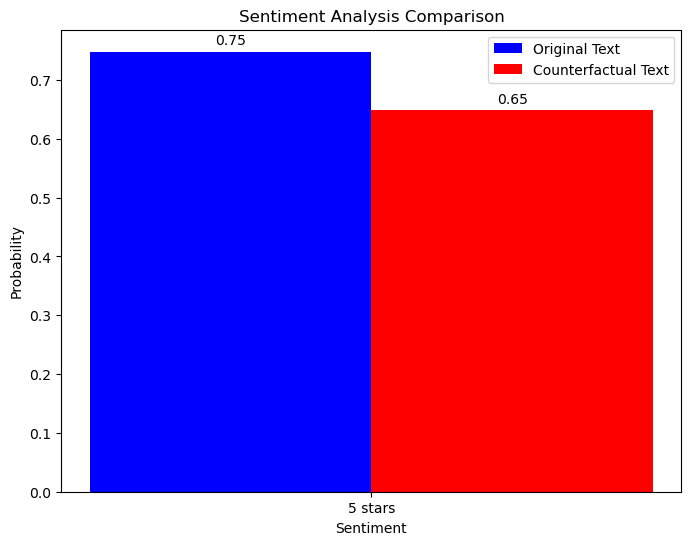

In [4]:


# Load sentiment analysis pipeline
sentiment_model = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Original text
original_text = "The product quality is fantastic."
cf_text = "The product quality is terrible."

# Get predictions
original_prediction = sentiment_model(original_text)
cf_prediction = sentiment_model(cf_text)

# Extract sentiment labels and probabilities
labels = [pred['label'] for pred in original_prediction]
original_probs = np.array([pred['score'] for pred in original_prediction])
cf_probs = np.array([pred['score'] for pred in cf_prediction])

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
index = np.arange(len(labels))

bar1 = ax.bar(index, original_probs, bar_width, label='Original Text', color='b')
bar2 = ax.bar(index + bar_width, cf_probs, bar_width, label='Counterfactual Text', color='r')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Probability')
ax.set_title('Sentiment Analysis Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

# Add probabilities on top of the bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.show()




In [5]:
print(f"Original Text: {original_text} -> Prediction: {original_prediction}")
print(f"Counterfactual Text: {cf_text} -> Prediction: {cf_prediction}")

Original Text: The product quality is fantastic. -> Prediction: [{'label': '5 stars', 'score': 0.7480428218841553}]
Counterfactual Text: The product quality is terrible. -> Prediction: [{'label': '1 star', 'score': 0.6487043499946594}]
